# License

The code in this notebook is free to be used, edited and redistributed by anyone free of charge. Please cite Linssen et al. (2024) when making use of _sunbather_ and/or the code in this notebook.

# Example goal

In this example notebook, we fit an observed He 10830 Å signal with a grid of Parker wind models in order to constrain the mass-loss rate of the planet. This is a commonly applied method (e.g., Paragas et al. 2021; Lampon et al. 2021), but it often results in a degeneracy between the free parameters of the Parker wind model: the temperature and the mass-loss rate. Constraints on the mass-loss rate are therefor usually not very stringent. In this notebook, we follow the approach described in Linssen et al. (2022), to mitigate this. We fit the helium line and combine this with additional constraints on the Parker wind temperature parameter, in order to break the degeneracy and get better constraints on the mass-loss rate. We use the helium signal of WASP-52 b as observed by Kirk et al. (2022).

# Example layout

Doing a concise analysis requires running a grid of Parker wind models with different temperatures ($T_0$) and mass-loss rates ($\dot{M}$), which can be computationally expensive (depending on the size of the grid). Here, we run a very small (3x3) grid of Parker wind models in order to demonstrate the technique and code commands, while keeping the computational time to a minimum. The output files of this small grid can then be substituted by output files of a larger grid, which we pre-ran and provide in the /examples/materials/ folder.

The analysis consists of four main steps:

- Step 1. Generate the $T_0$-$\dot{M}$ grid of isothermal (!) Parker wind models.
- Step 2. Run the Parker wind models through Cloudy to find a non-isothermal temperature profile and the metastable helium density.
- Step 3. Make synthetic helium transit spectra for each model and fit those to the observed value.
- Step 4. Constrain the temperature parameter-space by assessing the model self-consistency.
- Step 5. Combine the data fit with the model self-consistency to obtain the posterior and constrain the mass-loss rate.

Some of the steps we need to take to go through this analysis have to be taken outside of *sunbather* (e.g. storing the planet parameters in the planets.txt file, making the stellar SED available to *Cloudy*). Some steps are part of the "core functionality" of the *sunbather* package, which means they can be executed with a single command-line call to a Python script (e.g. generating the Parker wind profiles, running them through the Cloudy algorithm). And some of the steps are performed inside a user-made Python file/Jupyter notebook (e.g. saving the helium spectrum of each Parker wind profile, doing the Bayesian analysis to extract the mass-loss rate). In this notebook, we will provide all neccessary code.

# Preparation

For this exercise, we assume you have all codes set-up. That is; you have downloaded *sunbather* and installed its dependencies (the Python packages, including *p-winds*). You have installed *Cloudy v17.02* and have the path to it stored as your _$CLOUDY_PATH_ environmental variable. You have created your "project" folder, and have the path to it stored as your _$SUNBATHER_PROJECT_PATH_ environmental variable. You have copied the _planets.txt_ file to the project path. These steps are described in more detail in the "installation" section of the _sunbather_ wiki.

Before *sunbather* can create Parker wind profiles, we need to make sure the parameters of the system are available to the code. The parameters are stored in the _$SUNBATHER_PROJECT_PATH/planets.txt_ file, and the parameters of the WASP-52 b system have already been added. If you want to model additional planets, you can simply add lines in the _planets.txt_ file with their parameters, there is no need to replace previous planet parameters. The last column of the _planets.txt_ file specifies the **name** of the stellar SED that we want to use. The SED with exactly this name must be available to *Cloudy*, so it must be placed in its source folder, specifically: _/path/to/c17.02/data/SED/_. In the _/sunbather/stellar_SEDs/_ folder, we have provided the SED that we are going to use for WASP-52 b. This is the MUSCLES spectrum (France et al. 2016; Youngblood et al. 2016; Loyd et al. 2016) of eps Eri, which is a similar spectral type to WASP-52. The code is very specific about the format of the spectrum, so we refer to the wiki on how to prep your stellar SED for *sunbather*. 
> **The only step you need to take here, is make sure the eps_Eri_binned.spec is in Cloudy's SED folder: /path/to/c17.02/data/SED/ (so copy/move it there).**

# Step 1: Create a grid of Parker wind profiles with p-winds

This step can be done by calling `construct_parker.py` from the command-line with the proper arguments. Running `python construct_parker.py --help` will give an overview of the available arguments. In our case, we will run *p-winds* with a 90% hydrogen, 10% helium composition, which is done by passing `-fH 0.9`. We will run a 3x3 grid of models that span temperatures $T_0$=8000, 9000, 10000 and log10-mass-loss rates $\dot{M}$=10, 10.5, 11. To run a grid of temperatures, we need to pass the lowest temperature, the highest temperature, and the step size to the `-T` argument, and similarly for the log-10 mass-loss rate `-Mdot`. Since in the future, we may want to explore different compositions, `construct_parker.py` always expects you to give a folder name `-pdir` where we want to store our Parker profiles. We reccommend using a descriptive name, so in this case we will go with *fH_0.9* and the path where our profiles will be saved is then _/projectpath/parker_profiles/WASP52b/fH_0.9/_.

> **The full command to create our grid of Parker wind models thus becomes - go ahead and run it**: <br><br>
> `python construct_parker.py -plname WASP52b -pdir fH_0.9 -T 8000 10000 1000 -Mdot 10 11 0.5 -fH 0.9`

For this set of parameters, this command should take on the order of 10 seconds. In the _/projectpath/parker_profiles/WASP52b/fH_0.9/_ folder, there should now be 9 different .txt files with the isothermal Parker wind structures, feel free to inspect them!

# Step 2: Run the Parker wind profiles through Cloudy

This step can be done by calling `convergeT_parker.py` from the command-line with the proper arguments (`--help` will explain these). The $T_0$ and $\dot{M}$ grid-commands are the same as in Step 1. We also again need to specify a folder name where we want to save our *Cloudy* simulations. In this case we will just give it the same name as the folder we chose for the Parker wind profiles: `-dir fH_0.9` and so our simulations will be saved in _/projectpath/sims/1D/WASP52b/fH_0.9/_. We now again need to specify the folder where we want to read the Parker wind profiles from: `-pdir fH_0.9`. Since the *Cloudy* simulations are more time-consuming, you can easily run the different simulations in parallel by passing `-cores 2`. The last thing we need to think about, is for which atomic/ionic species we want to save *Cloudy's* output. You can in principle save everything that's available, but this generally results in large file sizes. In our particular case, we want to fit helium observations, so we are fine with just saving the densities of the different atomic helium energy levels: `-save_sp He`. We do not specify the composition to *Cloudy*, and hence the default solar composition will be used (which includes metals).

> **The full command to run our grid of Parker wind models through *Cloudy* thus becomes - go ahead and run it**: <br><br>
> `python convergeT_parker.py -plname WASP52b -dir fH_0.9 -pdir fH_0.9 -T 8000 10000 1000 -Mdot 10 11 0.5 -cores 2 -save_sp He`

For this set of parameters, this command should take on the order of 30 min. In the _/projectpath/sims/1D/WASP52b/fH_0.9/_ folder, there should now be 9 different sub-folders, with the output of the _Cloudy_ simulations, feel free to inspect the files! The _converged.png_ file shows the converged temperature structure, and the other _converged.*_ files are the _Cloudy_ output files.

# Step 3: Make transit spectra of the metastable helium triplet and fit the data

To make transit spectra, we can make use of the `FinFout_1D()` module in `RT.py`. This code does not run from the command line, as you may want to process/plot/save the resulting transit spectrum in different ways. In our case, we will quickly plot one helium spectra that we make, and then run all 9 models and integrate them to obtain the equivalent width (EW) of each spectral line, which we will compare to the observed EW value.

The `FinFout_1D()` function takes a `Sim` object, which is a class defined in `tools.py`. For more information on how to use this class, we refer to the wiki. The `FinFout_1D()` function takes three required arguments: the `Sim` object, a wavelength array in angstrom and vacuum, and the atomic/ionic species (or a list thereof) which to include in the calculations. In our case, we only need atomic helium, i.e. "He". There are a few optional arguments (see wiki), for example to specify a limb-darkening law or transit phase, but we will not use those here.

In [9]:
import sys
sys.path.append('/Users/dion/src/sunbather/src/') #add your path to /sunbather/src/ here

import tools
import RT

import pandas as pd
from scipy.integrate import trapezoid
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as sps

Before we calculate the EW of the different Parker wind profiles, let's plot one transit spectrum of the helium line for illustration purposes.

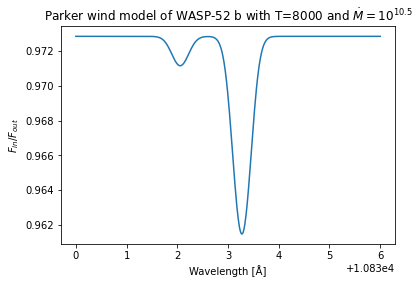

In [2]:
wavs = np.linspace(10830, 10836, num=500) #set up wavelength grid
sim = tools.Sim(tools.projectpath+'/sims/1D/WASP52b/fH_0.9/parker_8000_10.500/converged') #load simulation
transit_spectrum, lines_found, lines_not_found = RT.FinFout_1D(sim, wavs, 'He') #do RT

fig, ax = plt.subplots(1)
ax.plot(wavs, transit_spectrum)
ax.set_xlabel('Wavelength [Å]')
ax.set_ylabel(r'$F_{in} / F_{out}$')
ax.set_title(r'Parker wind model of WASP-52 b with T=8000 and $\dot{M}=10^{10.5}$')
plt.show()

Now, we will calculate the helium line of every Parker wind profile, and calculate its EW. We "fit" these EW values to the observed EW from Kirk et al. (2022) and save the **number of error-bars** discrepancy between model and data to a file. Under the assumption of normally distributed errorbars, this can be converted into a likelihood. If instead of fitting the EW of the line, you want to fit a spectrally resolved line, you would have to edit the code below to for example calculate a chi-squared value and save that to file.

In [11]:
def calc_EWs_He10830(Tstrucpath):
    '''
    Reads in all Parker wind profiles present in the Tstrucpath folder,
    calculates the metastable helium line and integrates it to get the EW.
    '''

    Mdots = ["%.3f" % Mdot for Mdot in np.arange(8.0,12.1,0.1)] #set up a grid of Mdot
    T0s = ["%i" % T0 for T0 in np.arange(2000,12100, 100)] #set up a grid of T_0
    
    EWs = pd.DataFrame(columns=Mdots, index=T0s, dtype=float)

    for Mdot in Mdots:
        for T0 in T0s:
            try:
                #read in the converged simulation for this combination of T0 and Mdot by specifying the path
                sim = tools.Sim(Tstrucpath+'parker_'+T0+'_'+Mdot+'/converged')
                #set up the wavelength array in vacuum angstrom units
                wavs = np.logspace(np.log10(10831), np.log10(10835), num=100)
                #run the radiative transfer (to check if all lines were calculated, print lines_found)
                FinFout, lines_found, lines_not_found = RT.FinFout_1D(sim, wavs, 'He')
                #convert from Fin/Fout to excess absorption
                absorption = np.max(FinFout) - FinFout
                #integrate to get EW
                EW = trapezoid(absorption, x=wavs)
                #save EW value in the pandas dataframe
                EWs[Mdot][T0] = EW
                
            except FileNotFoundError as e: #then this Parker wind model was not calculated
                pass
            
            except Exception as e: #if something else went wrong
                print(e)

    return EWs
    

EWs = calc_EWs_He10830(tools.projectpath+'/sims/1D/WASP52b/fH_0.9/')

observed_EW = 0.0403 #in Å, from Kirk et al. (2022)
observed_EW_err = 0.0061 #see Linssen et al. (2022) for how this was calculated 

nsig_fit = (EWs - observed_EW)/observed_EW_err #number of errorbars discrepancy between model and data
nsig_fit.to_csv('WASP52b_nsig_fit.csv')

We have now calculated the EWs of our 3x3 Parker wind grid. To do a meaningful analysis, we need to run a much larger grid of Parker wind models with different $T_0$ and $\dot{M}$. We have pre-ran such a larger grid and calculated the EWs of the helium line. You can find the _WASP52b_nsig_fit.csv_ file in the _/sunbather/examples/materials/_ folder. **In the analysis that follows, we will use the file from the _materials_ folder.**

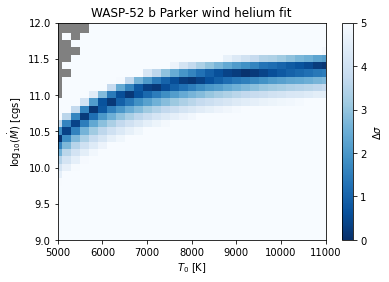

In [12]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=1000):
    '''
    Cuts a colormap to a smaller range.
    from https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    '''

    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def plot_fit(nsig_fit, bounds_T0=None, bounds_Mdot=None, title=None, save=None):
    '''
    Makes a standard plot of the Parker wind models fitted to the data.
    In this case, we fit the EW of the model to the EW of the data, and
    the colormap simply indicates how many data errorbars difference there is.
    '''
    
    cmap = plt.get_cmap('Blues_r')
    normalize = matplotlib.colors.Normalize(vmin=0, vmax=5)

    pixT = float(nsig_fit.index[1]) - float(nsig_fit.index[0]) #T step size
    pixM = float(nsig_fit.columns[1]) - float(nsig_fit.columns[0]) #Mdot step size

    
    fig, ax = plt.subplots(1)
    im = ax.imshow(nsig_fit.T.abs(), cmap=cmap, norm=normalize, origin='lower', aspect='auto', interpolation='none',
                      extent=[float(nsig_fit.index[0])-0.5*pixT, float(nsig_fit.index[-1])+0.5*pixT, 
                              float(nsig_fit.columns[0])-0.5*pixM, float(nsig_fit.columns[-1])+0.5*pixM])
    ax.set_facecolor('grey')
    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$) [cgs]')
    fig.colorbar(im, label=r'$\Delta\sigma$')
    if title != None:
        ax.set_title(title)
    if bounds_T0 != None:
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot != None:
        ax.set_ylim(*bounds_Mdot)
    if save != None:
        plt.savefig(save, bbox_inches='tight', dpi=500)
    plt.show()


#load the data from the file in the materials folder
nsig_fit = pd.read_csv('materials/WASP52b_nsig_fit.csv', index_col=0, dtype=float)
#We calculated the grid in steps of 200 K, but the nsig dataframe has steps of 100 K.
#To prevent a lot of empty cells in the image, we remove the empty T rows here:
nsig_fit = nsig_fit.iloc[::2, :] 
    
plot_fit(nsig_fit, bounds_T0=(5000, 11000), bounds_Mdot=(9, 12), title='WASP-52 b Parker wind helium fit')

Notice that there are some "holes" in the figures above, indicating failed models. The problem can be in _p-winds_, which sometimes fails to find a solution for specific combinations of $T_0$ and $\dot{M}$. If this is the case, the isothermal Parker wind profile will not be present in the */projectpath/parker_profiles/WASP52b/fH_0.9/* folder. The problem can also be a failed _Cloudy_ simulation, which can happen for example at high densities. If this is the case, you can go to the */project/sims/1D/WASP52b/fH_0.9/parker_"T0"_"Mdot"/* folder to find out why _Cloudy_ failed. Finally, in some cases the `convergeT_parker.py` module may fail to find a solution for the nonisothermal temperature structure. If this is the case, in the */project/sims/1D/WASP52b/fH_0.9/parker_"T0"_"Mdot"/* folder, you would find "iteration" files but no "converged" files. The algorithm may converge if you try the model again using a different starting criterion with the `-startT` flag, or if you let it run for longer by specifying a higher maximum number of iterations with the `-maxit` flag. In the case of this notebook, the missing models in the upper left corner are due to failed *p-winds* runs.

# Step 4: Constrain the Parker wind parameter space and apply Bayes' Theorem

We now assess the self-consistency of the Parker wind profiles in the helium line-forming region. To do that, we compare Cloudy's converged nonisothermal temperature profile to the initial isothermal value to identify models that are not self-consistent. As discussed in Linssen et al. (2022) and Linssen&Oklopcic (2023), there is not one single best way to do this comparison and it depends on the aim of the modeling effort. Since we are fitting helium observations here, we care most about the self-consistency of the Parker wind models in the region where the helium line forms. Thus, we calculate the mean of the nonisothermal temperature profiles weighted by the number density of metastable helium (this will be done by the `metaHe_weighted_T()` function and stored in the `T_He` variable and its standard deviation in the `sigmaT` variable). We then calculate the difference between this weighted temperature and the isothermal value $T_0$, which is the `dT` variable. This `dT` will be used for our prior on our Bayesian analysis. We are not confident in regions of the parameter space where |dT| >> 0 so we use a low prior there, while we are more confident in Parker wind models for which dT ~ 0 so we use a high prior there.

In [13]:
def metaHe_weighted_T(sim):
    '''
    Calculates the mean temperature and its standard devation of the atmosphere weighted by
    the metastable helium number density (Eq. 4 & 5 in Linssen et al. 2022).
    '''
    
    #in Cloudy, not all bins have the same thickness, so we must compensate for that to do a fair weighting
    bin_thickness = np.diff(np.insert(sim.den.depth.values, 0, 0.))
    #the metastable helium state is the second lowest energy level and thus stored in the He[2] column of the density file
    T_He = np.sum(sim.ovr.Te.values * sim.den['He[2]'].values * bin_thickness) / np.sum(sim.den['He[2]'].values * bin_thickness)
    sigmaT = np.sqrt( np.sum(sim.den['He[2]'].values * bin_thickness * (sim.ovr.Te.values - T_He)**2) / np.sum(sim.den['He[2]'].values * bin_thickness) )
    return T_He, sigmaT


def calc_dT(Tstrucpath):
    '''
    Reads in all Parker wind profiles present in the Tstrucpath folder,
    calculates the mean temperature weighted by the metastable helium density
    and its standard deviation. Calculates the temperature difference between
    the isothermal value and the He-weighted value, which can be used as 
    a measure of model self-consistency.
    '''
    
    Mdots = ["%.3f" % Mdot for Mdot in np.arange(8.0,12.1,0.1)] 
    T0s = ["%i" % T0 for T0 in np.arange(2000,12100, 100)]

    T_He = pd.DataFrame(columns=Mdots, index=T0s, dtype=float) #stores the weighted T
    sigmaT = T_He.copy() #stores standard deviation of T(r) around T_He
    dT = T_He.copy() #stores T_He - isothermal T

    for Mdot in Mdots:
        for T0 in T0s:
            try:
                sim = tools.Sim(Tstrucpath+'/parker_'+T0+'_'+Mdot+'/converged') #load the converged simulation
                ClT, ClsigmaT = metaHe_weighted_T(sim) #find the T_He and sigT_He for this simulation
                T_He[Mdot][T0] = ClT
                sigmaT[Mdot][T0] = ClsigmaT
                dT[Mdot][T0] = ClT - int(T0)

            except FileNotFoundError: #then this profile was not calculated
                pass
            
    return dT, sigmaT

dT, sigmaT = calc_dT(tools.projectpath+'sims/1D/WASP52b/fH_0.9')

dT.to_csv('WASP52b_dT.csv', float_format='%.3e')
sigmaT.to_csv('WASP52b_sigmaT.csv', float_format='%.3e')

We have now calculated the self-consistency of our 3x3 Parker wind grid. To do a meaningful analysis, we need to run a much larger grid of Parker wind models with different $T_0$ and $\dot{M}$. We have pre-ran such a larger grid and calculated the self-consistency of the models. You can find the _WASP52b_dT.csv_ and _WASP52b_sigmaT.csv_ files in the _/sunbather/examples/materials/_ folder. **In the analysis that follows, we will use the files from the _materials_ folder.**

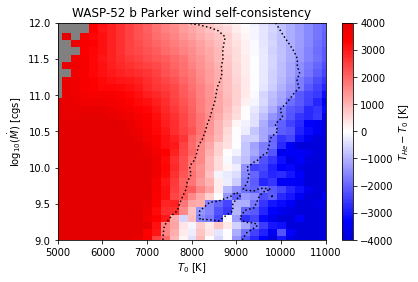

In [14]:
def plot_selfcons(dT, sigmaT, bounds_T0=None, bounds_Mdot=None, title=None):
    '''
    Makes a standard plot of the self-consistency of the Parker wind parameter space.
    Self-consistent models are white, while blue/red models indicate models for which
    Cloudy indicates that the temperature in the helium line-forming region is
    cooler/hotter than that assumed in creating the isothermal profiles, respectively.
    The dotted lines indicate 1 standard deviation discrepancy. 
    '''
    
    cmap = truncate_colormap(plt.get_cmap('seismic'), 0.2, 0.8)
    normalize = matplotlib.colors.Normalize(vmin=-4000, vmax=4000)

    pixT = float(dT.index[1])-float(dT.index[0]) #T step size
    pixM = float(dT.columns[1]) - float(dT.columns[0]) #Mdot step size

    
    fig, ax = plt.subplots(1)
    im = ax.imshow(dT.T, cmap=cmap, norm=normalize, origin='lower', aspect='auto', interpolation='none',
                      extent=[float(dT.index[0])-0.5*pixT, float(dT.index[-1])+0.5*pixT, 
                              float(dT.columns[0])-0.5*pixM, float(dT.columns[-1])+0.5*pixM])
    #plot the 1 sigma line (i.e. dT = sigmaT)
    sig1lines = ax.contour(dT.index.astype(float), dT.columns.astype(float), (dT / sigmaT).T, 
                           levels=[-1,1], zorder=1, colors='black', linestyles='dotted')
    ax.set_facecolor('grey')
    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$) [cgs]')
    fig.colorbar(im, label=r'$T_{He} - T_0$ [K]')
    if title != None:
        ax.set_title(title)
    if bounds_T0 != None:
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot != None:
        ax.set_ylim(*bounds_Mdot)
    plt.show()


#load the data from the files in the materials folder
dT = pd.read_csv('materials/WASP52b_dT.csv', index_col=0, dtype=float)
sigmaT = pd.read_csv('materials/WASP52b_sigmaT.csv', index_col=0, dtype=float)
dT = dT.iloc[::2, :]
sigmaT = sigmaT.iloc[::2, :]
    
plot_selfcons(dT, sigmaT, bounds_T0=(5000, 11000), bounds_Mdot=(9,12), title='WASP-52 b Parker wind self-consistency')

# Step 5: Combining the data fit and model self-consistency into a "joint-constraint"

Now that we have both the fit of the models to the data, and the constraints on the self-consistency of the parameter space, we can combine the two in a Bayesian framework to get a posterior distribution of the temperature and mass-loss rate of TOI-2134 b. As a reminder, Bayes' theorem reads as follows:

$P(T_0,\dot{M} | data) = \dfrac{P(data | T_0, \dot{M}) \times P(T_0, \dot{M})}{P(data)} = \dfrac{P(data | T_0, \dot{M}) \times P(T_0, \dot{M})}{\int P(data | T_0, \dot{M}) \times P(T_0, \dot{M}) \; dT_0 \; d\dot{M}}$

Here, $P$ denotes any probability quantity. $P(T_0,\dot{M} | data)$ is the *posterior* distribution of $T_0$ and $\dot{M}$ (given the data, i.e. our observed helium line). This is what we want to know. $P(data | T_0, \dot{M})$ is the *likelihood* of the data, so this is what we get from fitting our data with a model as done in Step 3. $P(T_0, \dot{M})$ is the *prior* expectation of how likely each model is (i.e. the self-consistency of the Parker wind models based on the temperature and not the data). $P(data)$ is what is called the *(model) evidence* and is basically a normalization factor. Here we write it as the integral over all considered models, which assumes that the true values of $T_0$ and $\dot{M}$ are within our considered parameter space. In our example, this assumption is probably fine, but if you run a scenario with a very limited extent of the $T_0-\dot{M}$ parameter space, the assumption might break and the posterior that you get from this code will not be robust.

The `calc_posterior()` function below evaluates Bayes' theorem and gives us the posterior distribution. `plot_posterior()` plots this for us and calculates the 1 $\sigma$ constraints on $T_0$ and $\dot{M}$ of the posterior. Remember that for a 1D Gaussian, the 1, 2 and 3 $\sigma$ contours are defined by the area that comprises 68%, 95% and 99.7% of the probability density function. However, for a 2D Gaussian, these values are 39%, 86% and 89.9% (see e.g. https://corner.readthedocs.io/en/latest/pages/sigmas/).

In [15]:
def calc_posterior_unresolved(nsig_T, nsig_fit):
    '''
    Combines the prior from the T0-T_He analysis (=nsig_T) with the likelihoods
    from the data fit (=nsig_fit), with Bayes' theorem, 
    to calculate the posterior (=joint constraint).
    
    See Linssen et al. 2022 for details on the choice of prior evaluation.
    '''

    #check that the prior and likelihoods are defined on the same T-Mdot grid
    assert np.array_equal(nsig_T.index.values, nsig_fit.index.values), "Different temperature grids."
    assert np.array_equal(nsig_T.columns.values, nsig_fit.columns.values), "Different mass-loss rate grids."

    T0grid = nsig_T.index.values.astype(float)
    Mdotgrid = nsig_T.columns.values.astype(float)

    #ASSUME prior is a normal distribution around dT=0 with std dev sigmaT
    #we don't need to normalize the prior, as we normalize prior*likelihood later
    prior = sps.norm.pdf(nsig_T)
    likelihood = sps.norm.pdf(nsig_fit.abs())
    integrand = prior*likelihood
    integrand[np.isnan(integrand)] = 0.
    evidence = trapezoid(trapezoid(integrand, axis=1, x=Mdotgrid), x=T0grid)
    posterior = integrand / evidence

    posterior = pd.DataFrame(columns=nsig_T.columns.values, index=nsig_T.index.values, 
                             data=posterior, dtype=float) #turn into pd.DataFrame

    return posterior


#first calculate the number of sigma "T-inconsistency" of the models. 
#e.g. a model with T_He - T_0 = 1000 K and sigma_T_He = 500 K is a 2 sigma inconsistency.
nsig_T = dT / sigmaT 

post = calc_posterior_unresolved(nsig_T, nsig_fit)

1 sigma constraints:
log10(Mdot) = 11.3 + 0.09999999999999964 - 0.10000000000000142
T0 = 9600.0 + 800.0 - 1000.0


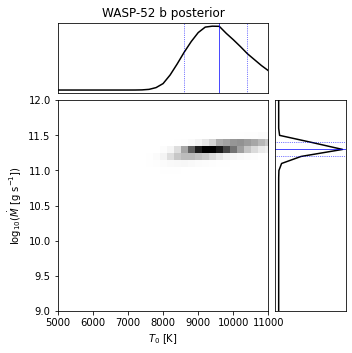

In [16]:
def plot_posterior(posterior, bounds_T0=None, bounds_Mdot=None, title=None, save=None, log=False):
    '''
    Plots the posterior distribution and the marginalized distributions.
    Prints the 1 sigma confidence intervals, at the precision of the T0/Mdot-grid.
    '''

    T0grid = posterior.index.values.astype(float)
    Mdotgrid = posterior.columns.values.astype(float)
    post = posterior.values
    
    pixT = np.diff(T0grid)[0] #T step size
    pixM = np.diff(Mdotgrid)[0] #Mdot step size

    #calculate marginalized posteriors
    post_Mdot = trapezoid(post, axis=0, x=T0grid)
    post_T0 = trapezoid(post, axis=1, x=Mdotgrid)

    post_Mdot_cum = cumulative_trapezoid(post_Mdot, x=Mdotgrid)
    lowsig_Mdot = Mdotgrid[np.argmax(post_Mdot_cum > 0.16)]
    mid_Mdot = Mdotgrid[np.argmin(np.abs(post_Mdot_cum - 0.5)) + 1]
    upsig_Mdot = Mdotgrid[np.argmax(post_Mdot_cum > 0.84) + 1]
    print(f"1 sigma constraints:\nlog10(Mdot) = {mid_Mdot} + {upsig_Mdot-mid_Mdot} - {mid_Mdot-lowsig_Mdot}")

    post_T0_cum = cumulative_trapezoid(post_T0, x=T0grid)
    lowsig_T0 = T0grid[np.argmax(post_T0_cum > 0.16)]
    mid_T0 = T0grid[np.argmin(np.abs(post_T0_cum - 0.5)) + 1]
    upsig_T0 = T0grid[np.argmax(post_T0_cum > 0.84) + 1]
    print(f"T0 = {mid_T0} + {upsig_T0-mid_T0} - {mid_T0-lowsig_T0}")


    fig = plt.figure(figsize=(5, 5))
    gs = fig.add_gridspec(2, 2,  width_ratios=(3, 1), height_ratios=(1, 3),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1, 0])
    ax_T0 = fig.add_subplot(gs[0, 0])
    ax_Mdot = fig.add_subplot(gs[1, 1])

    im = ax.imshow(post.T, cmap=plt.get_cmap('Greys'), origin='lower', aspect='auto', interpolation='none',
                extent=[T0grid[0]-0.5*pixT, T0grid[-1]+0.5*pixT, 
                        Mdotgrid[0]-0.5*pixM, Mdotgrid[-1]+0.5*pixM])
    if log:
        im.set_norm(matplotlib.colors.LogNorm())
    ax_T0.plot(T0grid, post_T0, color='k')
    ax_Mdot.plot(post_Mdot, Mdotgrid, color='k')


    ax_T0.axvline(mid_T0, color='blue', linewidth=0.7)
    ax_T0.axvline(lowsig_T0, color='blue', linewidth=0.7, linestyle='dotted')
    ax_T0.axvline(upsig_T0, color='blue', linewidth=0.7, linestyle='dotted')
    ax_Mdot.axhline(mid_Mdot, color='blue', linewidth=0.7)
    ax_Mdot.axhline(lowsig_Mdot, color='blue', linewidth=0.7, linestyle='dotted')
    ax_Mdot.axhline(upsig_Mdot, color='blue', linewidth=0.7, linestyle='dotted')

    ax_T0.set_xticks([])
    ax_T0.set_yticks([])
    ax_Mdot.set_xticks([])
    ax_Mdot.set_yticks([])

    ax.set_xlim(T0grid[0]-0.5*pixT, T0grid[-1]+0.5*pixT)
    ax_T0.set_xlim(T0grid[0]-0.5*pixT, T0grid[-1]+0.5*pixT)
    ax.set_ylim(Mdotgrid[0]-0.5*pixM, Mdotgrid[-1]+0.5*pixM)
    ax_Mdot.set_ylim(Mdotgrid[0]-0.5*pixM, Mdotgrid[-1]+0.5*pixM)
    if bounds_T0 != None:
        ax_T0.set_xlim(*bounds_T0)
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot != None:
        ax_Mdot.set_ylim(*bounds_Mdot)
        ax.set_ylim(*bounds_Mdot)

    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$ [g s$^{-1}$])')
    if title != None:
        ax_T0.set_title(title)

    if save != None:
        plt.savefig(save, dpi=500, bbox_inches='tight')
    plt.show()


plot_posterior(post, bounds_T0=(5000,11000), bounds_Mdot = (9, 12), title="WASP-52 b posterior")

Min/max of the drawn 1 sigma contour:
log10(Mdot) = 11.3 + 0.08865426905400398 - 0.07028998916208451
T0 = 9400.0 + 741.8011204947343 - 746.4052596951042


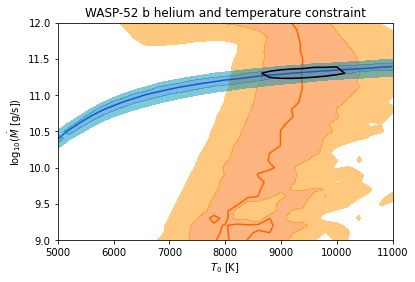

In [17]:
def get_array_from_contour(cn, levelnum):
    '''
    Takes an ax.contour object and returns the 'levelnum'-th contour as an
    array of x and y values. You can then extract the min/max values from
    such a contour/array.
    '''
    
    lines = []
    for line in cn.collections[levelnum].get_paths():
        lines.append(line.vertices)

    if lines:
        x = np.concatenate(lines, axis=0)[:,0]
        y = np.concatenate(lines, axis=0)[:,1]
    else:
        print("No 1 sigma contour could be found")
        x, y = None, None

    return x, y

def plot_joint_constraint_unresolved(nsig_T, nsig_fit, posterior, bounds_T0=None, bounds_Mdot=None, title=None, save=None, fig=None, ax=None):
    '''
    Makes a plot of the 1sigma posterior contour 
    on top of the prior (self-consistency) and likelihood (data fit) constraints.
    Also prints out the 1sigma bounds on T and Mdot, which are calculated
    based on the matplotlib contour, and thus involve interpolation to
    higher precision than the data itself.
    '''
    
    cmap_T = truncate_colormap(plt.get_cmap('autumn'), 0.35, 0.65)
    cmap_fit = truncate_colormap(plt.get_cmap('winter'), 0.35, 0.65)
    
    
    T0grid = nsig_T.index.values.astype(float)
    Mdotgrid = nsig_T.columns.values.astype(float)

    #calculate the posterior values that corresponds to the 1,2,3 sigma contours
    posterior_sorted = np.sort(posterior.values.flatten())[::-1]
    posterior_sum = np.sum(posterior_sorted)
    posterior_cumsum = np.cumsum(posterior_sorted)
    p1sigma = posterior_sorted[posterior_cumsum > 0.3935 * posterior_sum][0]
    p2sigma = posterior_sorted[posterior_cumsum > 0.8647 * posterior_sum][0]
    p3sigma = posterior_sorted[posterior_cumsum > 0.9889 * posterior_sum][0]
    
    if fig == None and ax == None:
        showplot = True
        fig, ax = plt.subplots(1)
    else:
        showplot = False
    
    #plot the Cloudy T constraints (i.e. prior):
    ax.contour(T0grid, Mdotgrid, nsig_T.T, cmap=cmap_T, levels=[0], zorder=0) #plots the orange line
    ax.contourf(T0grid, Mdotgrid, np.abs(nsig_T.T), cmap=cmap_T, levels=[0,1,2], alpha=0.5, zorder=0) #plots the orange contours
    
    #plot the fit constraints (i.e. likelihood):
    ax.contour(T0grid, Mdotgrid, nsig_fit.T, cmap=cmap_fit, levels=[0], zorder=1) #plots the blue line
    ax.contourf(T0grid, Mdotgrid, np.abs(nsig_fit.T), cmap=cmap_fit, levels=[0,1,2], alpha=0.5, zorder=1) #plots the blue contours
    
    #plot the joint posterior 1 sigma line:
    cn_post = ax.contour(T0grid, Mdotgrid, posterior.T, levels=[p1sigma], colors='black', zorder=2)
    
    #print the posterior 1sigma credible intervals:
    pT0, pMdot = get_array_from_contour(cn_post, 0) #get level 0 (=1 sigma) from posterior
    if pT0 is not None and pMdot is not None:
        bestT0_index, bestMdot_index = np.unravel_index(np.nanargmax(posterior), posterior.shape)
        bestT0, bestMdot = T0grid[bestT0_index], Mdotgrid[bestMdot_index] #T, Mdot of the maximum of the posterior
        max_pMdot, min_pMdot, max_pT0, min_pT0 = np.max(pMdot), np.min(pMdot), np.max(pT0), np.min(pT0) #
        print(f"Min/max of the drawn 1 sigma contour:\nlog10(Mdot) = {bestMdot} + {max_pMdot-bestMdot} - {bestMdot-min_pMdot}")
        print(f"T0 = {bestT0} + {max_pT0-bestT0} - {bestT0-min_pT0}")
    
    ax.set_xlabel(r'$T_0$ [K]')
    ax.set_ylabel(r'log$_{10}$($\dot{M}$ [g/s])')
    if bounds_T0:
        ax.set_xlim(*bounds_T0)
    if bounds_Mdot:
        ax.set_ylim(*bounds_Mdot)
        ax.set_yticks(np.arange(bounds_Mdot[0], bounds_Mdot[1] + 0.5, 0.5))
    if title != None:
        ax.set_title(title)
    if save != None:
        plt.savefig(save, bbox_inches='tight')
    if showplot:
        plt.show()
    
    
plot_joint_constraint_unresolved(nsig_T, nsig_fit, post, bounds_T0=(5000,11000), bounds_Mdot = (9, 12), 
                          title='WASP-52 b helium and temperature constraint')

In the above plots, the orange contours represent the prior: the self-consistency of the Parker wind models. It presents the same quantity ($dT = T_{He} - T_0$) as the red-white-blue plots from Step 4. The orange line are models with $dT=0$, and the dark and light shaded areas represent the 1 and 2 $\sigma_T$ contours (Eq. 5 of Linssen et al. 2022).  The blue contours represent the likelihood: the fits of the model to the observed helium line. It presents the same quantity ($\Delta \sigma$) as the plots from Step 3. The blue line are the models for which the EW is equal to that of the data, and the dark and light shaded areas represent 1 and 2 errorbars offset in EW. The black line represents the 1 $\sigma$ contour of the posterior and can be understood as the final constraints on the temperature and mass-loss rate of the planet.

# Results

And there we are! We have our constraint on the mass-loss rate and temperature of WASP-52 b. You may note that there are small differences between the constraints printed between the posterior plot and the joint-constraint plot. This is because the `plot_posterior()` function quotes the median and 1 $\sigma$ bounds of the marginalized $T_0$ and $\dot{M}$ posteriors, at the numerical precision of the ran parameter grid. The `plot_joint_constraint_unresolved()` function instead quotes the maximum and  $\sigma$ bounds of the 2D posterior surface, at the (interpolated and hence overestimated) numerical precision of the matplotlib `contour` plot. Here, we will summarize and quote the former constraints:

$T_0 = 9600^{+1000}_{-800}$ K

$\dot{M} = 10^{11.3 \pm 0.1}$ g/s

We finally note that the values here are slightly different from those reported in Linssen et al. (2022) for the same data. This is because there are small differences in the Parker wind models made by A. Oklopcic's private code (which were used in the publication) and *p-winds* (used here).

### References

France, K., Loyd, R. O. P., Youngblood, A., et al. 2016, ApJ, 820, 89

Kirk, J., Dos Santos, L. A., López-Morales, M., et al. 2022, AJ, 164, 24

Lampón, M., López-Puertas, M., Sanz-Forcada, J., et al. 2021, A&A, 647, A129

Linssen, D. C., Oklopcic, A., & MacLeod, M. 2022, A&A, 667, A54

Linssen, D. C. & Oklopcic, A. 2023, A&A, 675, A193

Loyd, R. O. P., France, K., Youngblood, A., et al. 2016, ApJ, 824, 102

Paragas, K., Vissapragada, S., Knutson, H. A., et al. 2021, ApJ, 909, L10

Youngblood, A., France, K., Loyd, R. O. P., et al. 2016, ApJ, 824, 101